#  **SCC0270 - Redes Neurais e Aprendizado Profundo**

## **Trabalho 1**

* Dataset: MedPix 2.0 with DR-Minerva and Knowledge Graph
* Multimodalidade: texto e imagem
* Problema: classificação multi-classe

* Arxiv: https://arxiv.org/html/2407.02994v1#S3
* Github: https://github.com/CHILab1/MedPix-2.0

## Introdução 

O objetivo do Trabalho 01 é construir um algoritmo de classificação binária para classificar as imagens da base MedPix-2.0, de acordo com as duas labels disponíveis `CP` e `MRI`. 

De início, utilizaremos descritores de imagens e texturas para extrair as características da imagem para construir os algoritmos de classificação.


In [23]:
# Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt

import warnings; warnings.filterwarnings("ignore")
import requests
import json
from PIL import Image
from io import BytesIO
import os
import cv2
import mahotas as mt 
from skimage import io 

In [5]:
# # Importar o MyDrive
# drive.mount('/content/drive')

## 0.0 - Informações sobre os dados 

Localmente, os dados estão presentes na pasta `MedPix-2.0`. Os dados com o split, estão na pasta `MedPix-2.0/splitted_dataset`.

Os dados foram divididos em dois tipos de Documentos JSON:

1. `Description Document`: dados com informações referentes apenas as imagens. 
2. `Case-Topic Document`: dados com informações relacionadas ao caso clínico. 

Existe uma relação do tipo **uma-para-muitos** entre um dado do tipo Descrition e outro do tipo Case-Topic.

O arquivo `uid_list.json` apresenta os UIds que foram utilizados na divisão das bases `Case_topic.json` e `Descriptions.json` nas bases de `train`, `train_1`, `train_2`, `dev` e `test`.

Portanto, utilizaremos as divisões realizadas pelos autores para o treinamento dos algoritmos.

## 0.1 Importando as descrições

In [6]:
def get_descriptions(url:str):

    # Importanto as descrições
    response = requests.get(url)
    # Separando por linha
    descricoes = response.text.splitlines() 
    return descricoes

In [7]:
GITHUB_URL = "https://raw.githubusercontent.com/CHILab1/MedPix-2.0/refs/heads/main/MedPix-2-0/splitted_dataset/descriptions_dev.jsonl"

In [8]:
# Exemplo: descrição da posição 0
get_descriptions(GITHUB_URL)[0]

'{"Type":"CT","U_id":"MPX1009","image":"MPX1009_synpic46283","Description":{"ACR Codes":"8.-1","Age":"73","Caption":"The prostate is enlarged with several calcifications  noted within.  No dominant prostate mass is evident.","Figure Part":null,"Modality":"CT - noncontrast","Plane":"Coronal","Sex":"male"},"Location":"Genitourinary","Location Category":"Reproductive and Urinary System"}'

In [9]:
def create_content_df(url:str):

    descricoes = get_descriptions(url)

    # Estruturando as informções em uma tabela
    dados = []
    for linha in descricoes:
        registro = json.loads(linha)
        descricao = registro.pop("Description")
        registro.update(descricao)
        dados.append(registro)

    # Criando o DataFrame
    df = pd.DataFrame(dados) 

    return df

In [10]:
# Visualizando as 5 primeiras linhas
df = create_content_df(GITHUB_URL)
df.head()

,Type,U_id,image,Location,Location Category,ACR Codes,Age,Caption,Figure Part,Modality,Plane,Sex
0,CT,MPX1009,MPX1009_synpic46283,Genitourinary,Reproductive and Urinary System,8.-1,73,The prostate is enlarged with several calcific...,None,CT - noncontrast,Coronal,male
1,CT,MPX1009,MPX1009_synpic46295,Genitourinary,Reproductive and Urinary System,8.-1,73,Bladder is prominent with mildly thickened wal...,None,CT - noncontrast,Axial,male
2,CT,MPX1075,MPX1075_synpic20513,"Chest, Pulmonary",Thorax,6.3,66,"1.6 x 1.8cm right middle lobe nodule, adjacent...",None,CT w/contrast (IV),Axial,female
3,CT,MPX1109,MPX1109_synpic28526,Gastrointestinal,Abdomen,7.0,33,Coronal reconstruction of the axial non-contra...,None,CT - noncontrast,Coronal,female
4,CT,MPX1135,MPX1135_synpic16704,Endocrine,Abdomen,8.3,30,Large soft tissue mass arising from left adren...,None,CT w/contrast (IV),Axial,male


## 0.2 Importando a imagem de um caso como exemplo

In [11]:
# Obtendo o nome da imagem associada ao caso 0
i = 0 # index da tabela
image_name = df['image'][0]

image_name

'MPX1009_synpic46283'

In [ ]:
# Plotando a imagem a partir do DRIVE (não rodar em ambiente local)

# Caminho para a imagem no drive
try:
    image_path = r'/content/drive/MyDrive/[Trabalho] SCC0270 - Redes Neurais e Aprendizado Profundo/images/'+ image_name +'.png'
    img = Image.open(image_path)
except Exception:
    #caminho local 
    image_path = f"./images/{image_name}.png" 
    img = Image.open(image_path)

# Mostrando a imagem
plt.imshow(img)
plt.axis('off')  # tira os eixos
plt.show()

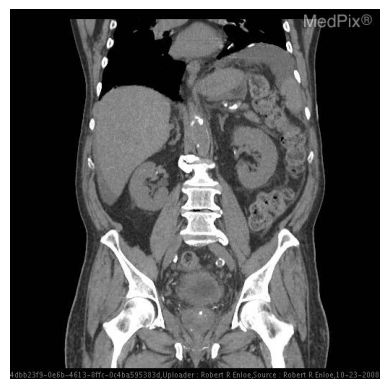

In [13]:
# Plotando a imagem a partir do GITHUB

def plot_image(image_name:str):
    # URL (raw) da imagem no GitHub
    url = 'https://raw.githubusercontent.com/CHILab1/MedPix-2.0/refs/heads/main/MedPix-2-0/images/'+ image_name +'.png'

    # Importando a imagem
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # Mostrando a imagem
    plt.imshow(img)
    plt.axis('off')  # tira os eixos
    plt.show() 

plot_image(image_name="MPX1009_synpic46283")

Exemplo de imagem de MR

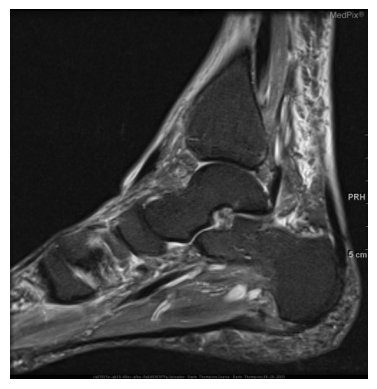

In [14]:
plot_image("MPX2586_synpic17310")

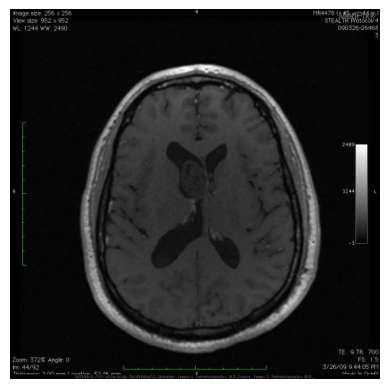

In [15]:
plot_image("MPX2607_synpic52590")

## Distribuicao das Imagens

Os autores mesmo buscaram construir o conjunto de dados de modo que ele fosse o mais balanceado possível entre as classes.

In [16]:
df.Type.value_counts(normalize=True)

Type
MR    0.573604
CT    0.426396
Name: proportion, dtype: float64

# **1 Desenvolvimento**

Como o objetivo do trabalho 01 é construir um classificador binário, usaremos apenas os dados do Documento Descriptions, referente às imagens. 

Usaremos os conjuntos de dados `train_1` e `train_2` para o treinamento, o conjunto `dev` para validação e o conjunto `test` para teste das predições.

Existem 1643 imagens no conjunto de treino sendo: 

* 810 imagens em `train_1`
* 843 imagens em `train_2`

## Organização das Imagens de Treino

In [17]:
DESCRIPTIONS_TRAIN_PATH = "./MedPix-2.0/splitted_dataset/descriptions_train.jsonl"

In [18]:
def read_train_data(path:str):
    
    with open(path, "r+") as f:
        lines = f.readlines()
    
        dados = []
        for linha in lines:
            registro = json.loads(linha)
            descricao = registro.pop("Description")
            registro.update(descricao)
            dados.append(registro)

    # Criando o DataFrame
    df = pd.DataFrame(dados) 

    return df

In [19]:
df_train = read_train_data(DESCRIPTIONS_TRAIN_PATH)

In [20]:
df_train.head()

,Type,U_id,image,Location,Location Category,ACR Codes,Age,Caption,Figure Part,Modality,Plane,Sex
0,CT,MPX1024,MPX1024_synpic40275,"Chest, Pulmonary",Thorax,-1.-1,60,CT of the chest reveals an obstructing mass an...,None,CT - noncontrast,Axial,female
1,CT,MPX1024,MPX1024_synpic40277,"Chest, Pulmonary",Thorax,-1.-1,60,CT of the chest reveals an obstructing mass an...,None,CT - noncontrast,Axial,female
2,CT,MPX1012,MPX1012_synpic22949,Genitourinary,Reproductive and Urinary System,8.2,14,pelvis,None,CT - GI & IV Contrast,Axial,female
3,CT,MPX1012,MPX1012_synpic22950,Genitourinary,Reproductive and Urinary System,8.2,14,pelvis,None,CT - GI & IV Contrast,Axial,female
4,CT,MPX1016,MPX1016_synpic34317,"Chest, Pulmonary",Thorax,6.3,43,Contrast enhanced chest CT shows diffuse incre...,2a,CT w/contrast (IV),Axial,female


In [27]:
images = []

train_img_path = read_train_data(DESCRIPTIONS_TRAIN_PATH)['image'] 

for img_name in train_img_path:
    img_name = "./MedPix-2.0/images/" + img_name + ".png"
    images.append(img_name)

## Gerando o dataset com as imagens

In [29]:
train_img_df = [] 
for img_url in images:
    try:
        image = io.imread(img_url) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        train_img_df.append(image) 
    except:
        print("Warning:", img_url)

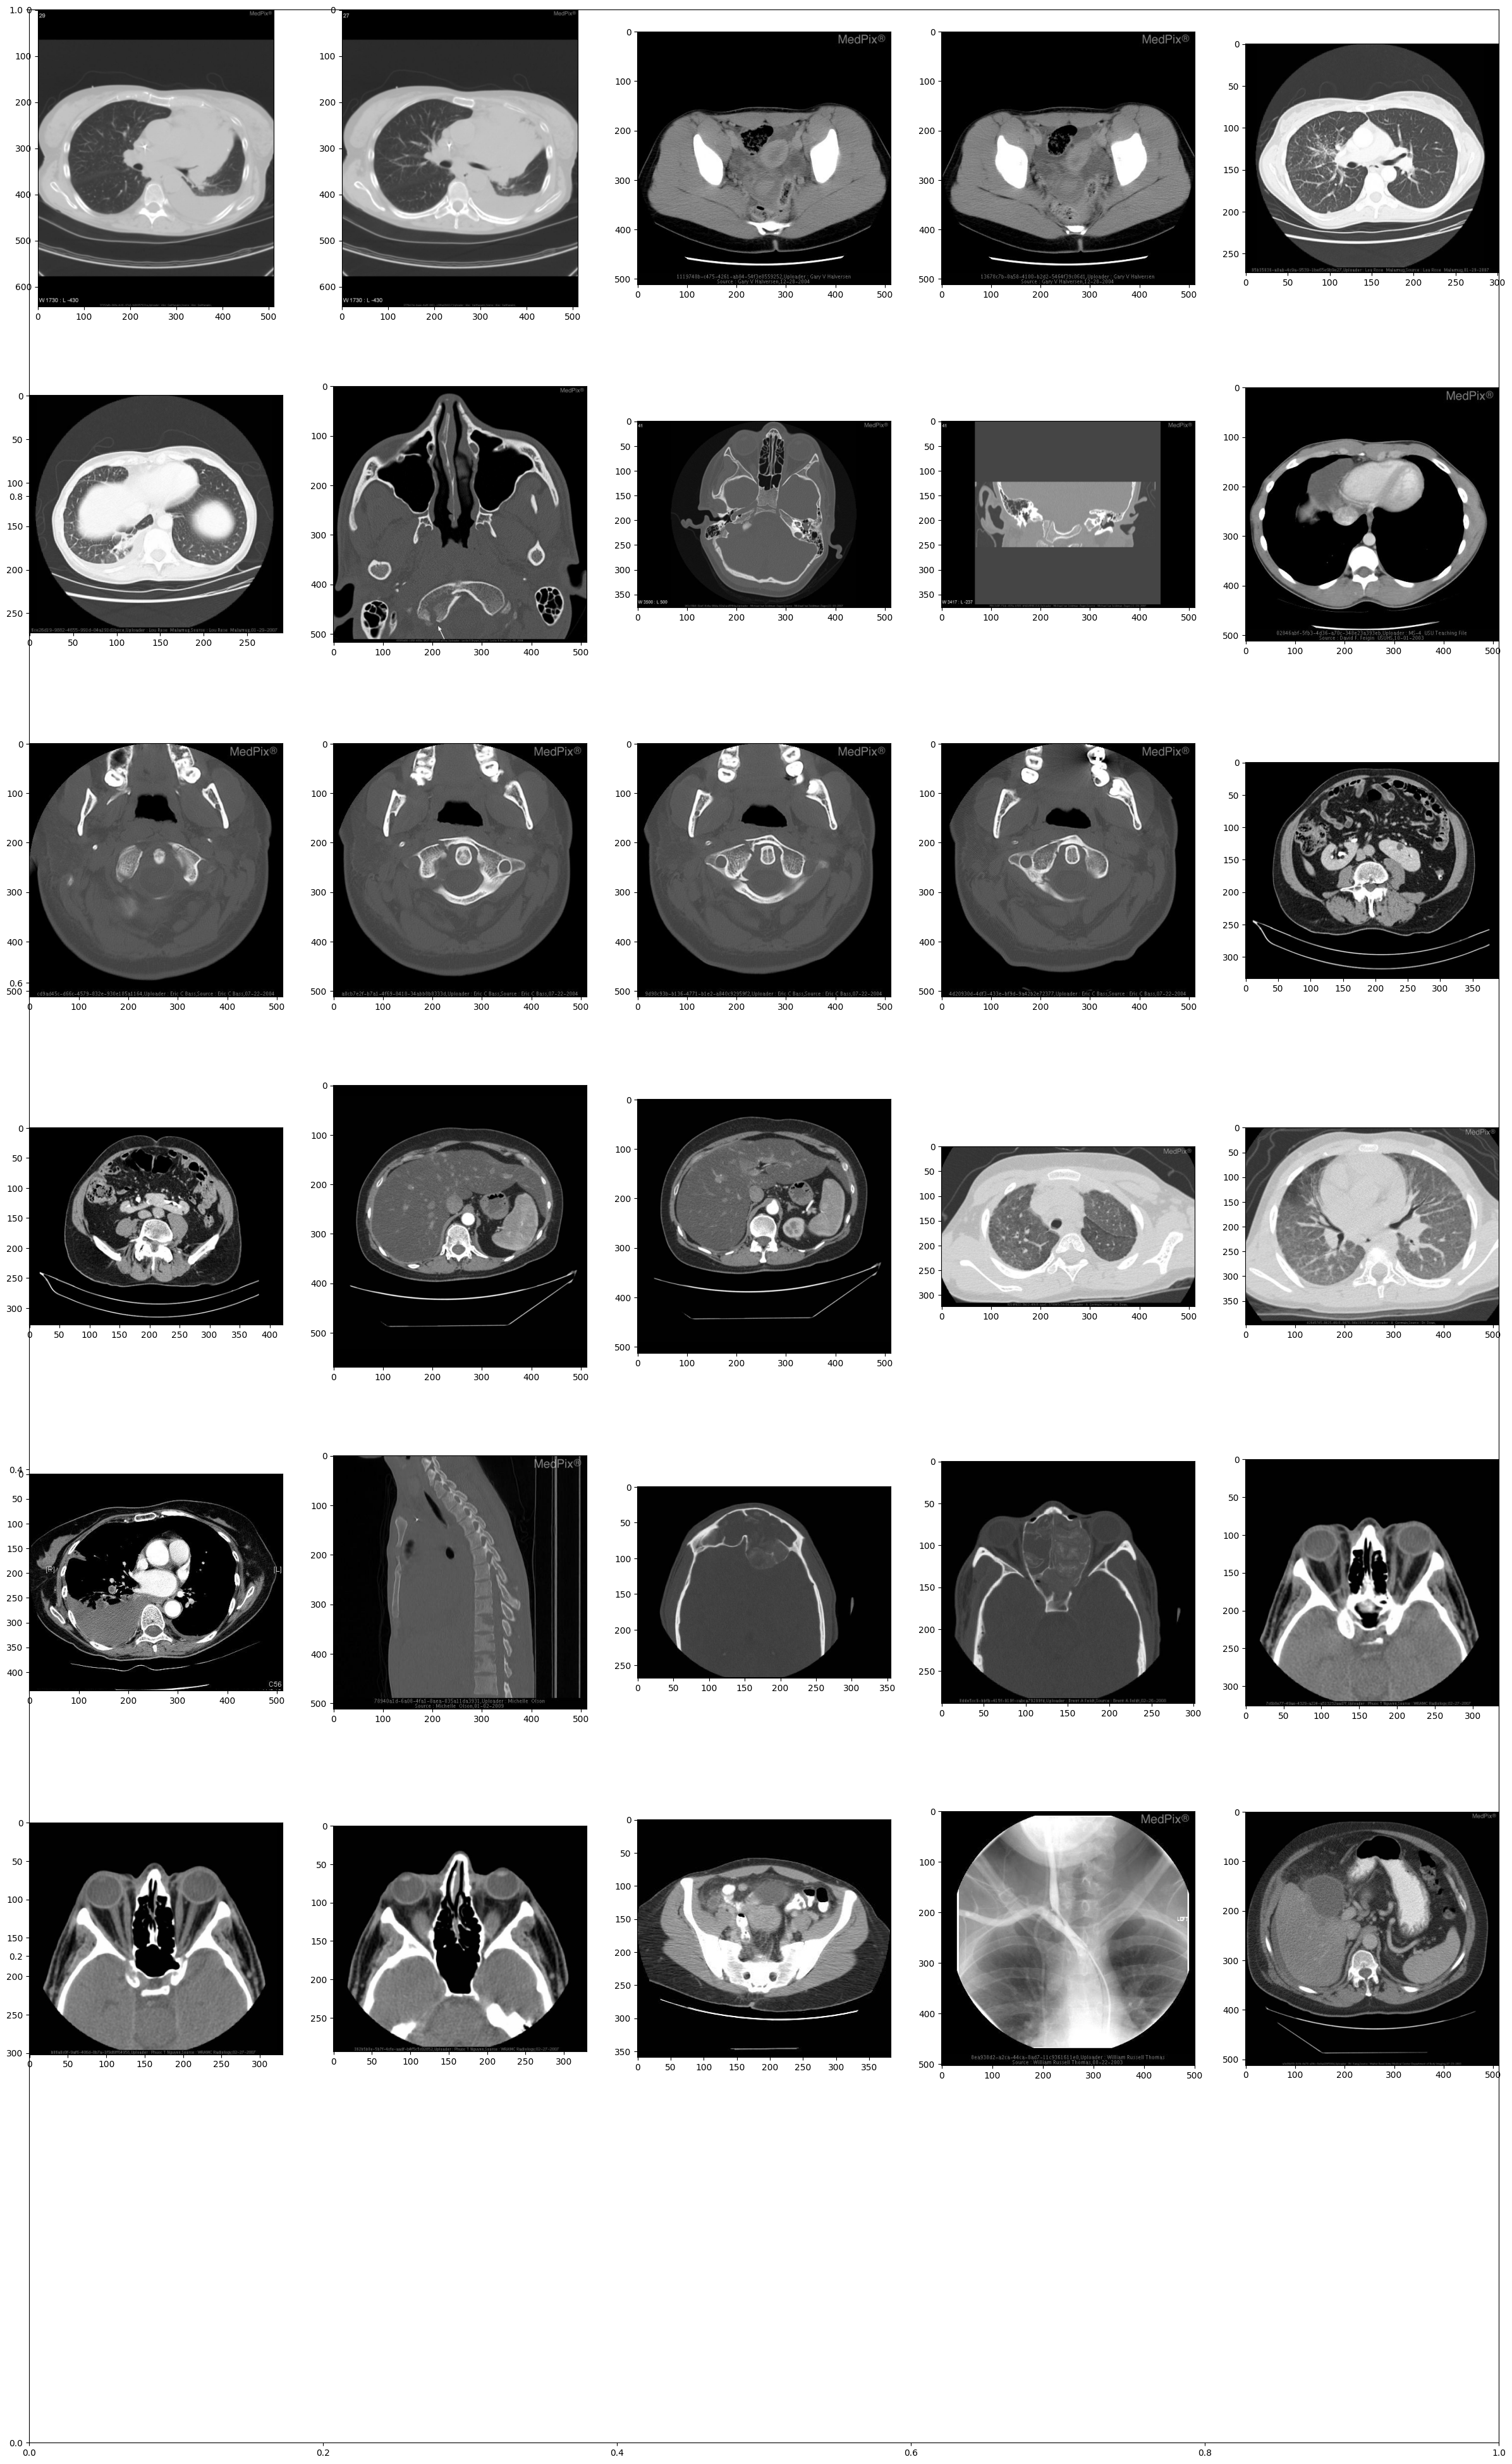

In [30]:
plt.subplots(figsize=(30,50)) 
columns=5 
for i, image in enumerate(train_img_df[:30]):
    plt.subplot(int(len(train_img_df[:30]) / columns + 1), columns, i + 1) 
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

## Extraindo Descritores de Textura